# 기술 통계량 & 키워드 추출

### 패키지 설치

In [3]:
# 나눔고딕 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


### 패키지 로드

In [6]:
import numpy as np
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

import pandas as pd
import pickle
import regex
import re
from tqdm.notebook import tqdm  
tqdm.pandas()
from collections import Counter
from itertools import chain

### 데이터 로드

In [9]:
!wget https://github.com/ByungjunKim/DDMKL/raw/main/phd.pickle

--2020-12-21 08:04:52--  https://github.com/ByungjunKim/DDMKL/raw/main/phd.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/phd.pickle [following]
--2020-12-21 08:04:53--  https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/phd.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19321951 (18M) [application/octet-stream]
Saving to: ‘phd.pickle’

phd.pickle          100%[===================>]  18.43M   119MB/s    in 0.2s    

2020-12-21 08:04:53 (119 MB/s) - ‘phd.pickle’ saved [19321951/19321951]



In [10]:
with open('phd.pickle', 'rb') as f:
    phd = pickle.load(f)

In [11]:
phd

,Index,대주제,장르,중주제1,중주제2,대상작가,시대별,서명,기타서명,저자,발행사항,대학,형태사항,일반주기명,학위논문사항,DDC,KDC,발행국,출판년,주제어,소장기관,UCI식별코드,국문 초록 (Abstract),다국어 초록 (Multilingual Abstract),목차,contents,tokens
0,1,작가론,시,시인론,NaN,서정주,통사,"徐廷柱 詩 硏究 = A study on the Poetry of Suh, Jung-Ju",NaN,연은순,"청주 : 청주대학교, 2000",청주대학교,174 p. ; 26 cm.,NaN,학위논문(박사)-- 청주대학교 대학원 : 국어국문학과 국문학전공 2000,NaN,811.6,서울,2000,,"강원대학교 도서관 (242002),국립중앙도서관 (011001),단국대학교 퇴계기념...",NaN,,"This dissertation aims at investigating Suh, J...",목차\r\nI. 서론 = 1\r\n 1. 문제제기 = 1\r\n 2. 연구사 검토 ...,서정주 시 연구 서정주 시 연구 ...,"[서정주, 시, 서정주, 시, 시어, 구사, 비문법성, 시성, 표출, 모순어법, 미..."
1,2,주제론,소설,소설주제론,NaN,NaN,1950,전후소설과 이데올로기의 상관성 연구 = (A) Study of Correlation...,NaN,이봉일,"서울 : 경희대학교 대학원, 2000",경희대학교,155p. : 삽도 ; 26cm.,NaN,학위논문(박사)-- 경희대학원 대학원: 국어국문학과 2000,NaN,813.6 4,서울,2000,전후소설 이데올로기 상관성,"경희대학교 중앙도서관 (211006),국립중앙도서관 (011001)",NaN,본논문은 '50년대 전후소설과 이데올로기의 상관성을 이해하는 데 목적이 있다. 그동...,The aim of this dissertation is to understand ...,Ⅰ. 서론 = 1\r\n 1. 문제제기 = 1\r\n 2. 연구사 검토 = 5\r\...,전후소설과 이데올로기의 상관성 연구 전후소설과 ...,"[전후, 소설, 이데올로기, 상관성, 전후, 소설, 이데올로기, 상관성, 전쟁, 이..."
2,3,주제론,비평,소설주제론,NaN,NaN,개화기,韓國 近代初期 文學論과 小說化 樣相 硏究,NaN,김윤재,"서울 : 韓國外國語大學校 大學院, 2000",한국외국어대학교,"ii, 165 p. ; 26 cm.",참고문헌 : p.158-163.,학위논문(박사)-- 韓國外國語大學校大學院 : 國語國文學 2000,895.1309 16,NaN,서울,2000,,"국립중앙도서관 (011001),한국외국어대학교 서울캠퍼스 도서관 (211059)",NaN,,NaN,"\n=0,1,3\n차례=i,4,2\nI. 서론=1,6,1\n1. 연구목적=1,6,2...",한국 근대초기 문학론과 소설화 양상 연구 한국 근대초기 문학론과 소설화 양상 연구 ...,"[근대, 초기, 문학론, 소설화, 근대, 초기, 문학론, 소설화, 차례, 현황, 계..."
3,4,비교문학,비평,비교문학,시인론,"조지훈,크리슈나무르티",통사,조지훈과 크리슈나무르티의 선적(禪的) 동질성 연구,NaN,김기호,"서울 : 한국외국어대학교 대학원, 2000",한국외국어대학교,163 p. ; 26 cm.,참고문헌 : p.154-159.,학위논문(박사)-- 한국외국어대학교대학원 : 국어국문 2000,895.1109 16,NaN,서울,2000,,"국립중앙도서관 (011001),한국외국어대학교 서울캠퍼스 도서관 (211059)",NaN,,NaN,"\n=0,1,3\n목차=i,4,1\nI. 서론=1,5,1\n1. 문제의 제기=1,5...",조지훈과 크리슈나무르티의 선적 선적 동질성 연구 조지훈과 크리슈나무르티의 선적 선...,"[조지훈, 크리슈나무르티, 선, 선, 동질성, 조지훈, 크리슈나무르티, 선, 선, ..."
4,5,주제론,소설,여성문학_젠더(해방 이후),소설주제론,NaN,1950,1950년대 한국소설의 여성인물 연구 : 현실수용양상을 중심으로 = (A)study...,NaN,송경란,"서울: 淑明女子大學校, 2000",숙명여자대학교,"iv, 158p.; 26cm",NaN,학위논문(박사) -- 숙명여자대학교 대학원: 국어국문학과 현대문학전공 2000,895.734 21,813.6 4,서울,2000,1950년대 소설 여성인물,"국립중앙도서관 (011001),숙명여자대학교 도서관 (211043),한국학중앙연구원...",NaN,이 논문은 1950년대 소설에서 전쟁과 전후상황에 의한 여성인물의 현실수용양상을 살...,"In this study, I tried to explain the influenc...",Ⅰ. 서론 ········································...,1950년대 한국소설의 여성인물 연구 현실수용양상을 중심으로 ...,"[1950년대, 소설, 여성, 인물, 현실, 수용, 1950, 1950년대, 소설,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,1524,작가론,소설,소설작가론,NaN,서정인,해방이후,서정인 소설의 변모 양상 연구 = A Study on Changing Aspects...,NaN,박희현,"서울 : 서울시립대학교 인문대학원, 2019",서울시립대학교,"ⅱ, 258 p. ; 26 cm",지도교수: 이동하,학위논문(박사)-- 서울시립대학교 인문대학원 : 국어국문학과 현대문학 2019. 8,NaN,NaN,서울,2019,미메시스 디에게시스 말의 중첩 언어적 다양성 상대주의적 세계관 인유(引喩) 판소리 ...,서울시립대학교 도서관 (211035),I804:11035-000000030867,본고는 서정인 소설 세계의 변모 양상을 작품을 통해 구체적으로 살펴보는 것을 연구의...,The purpose of this study is to examine aspect...,제1장. 서론 1&#xD;\n 제1절. 문제 제기 및 연구 목적 1&#xD;...,서정인 소설의 변모 양상 연구 서정인 소설의 변...,"[서정인, 소설, 변모, 서정인, 소설, 변모, 서술, 순서, 시대, 현실, 충실,..."
1524,1525,문화,기타_복합장르,여성문학_젠더(해방 이후),문학문화,NaN,1960~1970,'여류문학전집'(1967-1979)과 여성문학의 젠더 정치,NaN,김은석,"서울: 동국대학교, 2019",동국대학교,"iii, 189 p.; 26 cm.","동국대학교 논문은 저작권에 의해 보호받습니다.,지도교수: 김춘식,서지적 각주와 참고...",학위논문(박사)-- 동국대학교 대학원: 국어국문학과 2019. 2,NaN,NaN,서울,2019,여류문학전집 문학 장 한국여류문학인회 문학 장 정전,동국대학교 중앙도서관 (211020),I804:11020-000000079013,본 논문은 ‘여류문학전집’(1967~1979)을 중심으로 1960~70년대 여류문학...,The Women’s Literary Collection by Women Write...,Ⅰ. 서 론 1&#xD;\n 1. 연구 목적 및 연구사 검토 1&#xD;\n 2...,여류문학전집 1967 1979 과 여성문학의 젠더 정치 여류문학전집 1967 1...,"[여류, 전집, 여성, 젠더, 정치, 여류, 전집, 여성, 젠더, 정치, 1960년..."
1525,1526,작가론,비평,비평사,NaN,이어령,해방이후,이어령 문학비평 연구 = A Study of Lee O-young′s Literar...,NaN,홍래성,"서울 : 서울시립대학교 일반대학원, 2019",서울시립대학교,"ⅰ, 268 p. ; 26 cm",지도교수: 이동하,학위논문(박사)-- 서울시립대학교 일반대학원 : 국어국문학과 2019. 8,NaN,NaN,서울,2019,이어령 1950년대 전후세대 이상론 저항의 문학 퍼포머티브 전통론 김동리 사르트르 ...,서울시립대학교 도서관 (211035),I804:11035-000000030919,본 논문은 전후의 시기에 펼쳐진 이어령의 문학비평을 대상으로 그 

### 1. 기술 통계량

In [19]:
phd['출판년'].value_counts()

2003    103
2002     99
2005     91
2014     84
2012     84
2011     84
2010     84
2006     82
2008     82
2009     79
2013     75
2001     71
2000     71
2004     70
2007     65
2015     65
2016     65
2017     62
2019     57
2018     55
Name: 출판년, dtype: int64

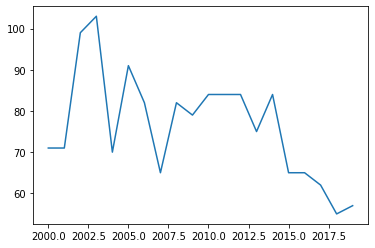

In [23]:
# 연도별 박사논문 출판건수 추이
phd['출판년'].value_counts(sort=False).plot()

In [12]:
phd['tokens'].str.len().describe()

count    1528.000000
mean      103.450262
std        49.089164
min         2.000000
25%        70.000000
50%        94.000000
75%       128.000000
max       443.000000
Name: tokens, dtype: float64

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


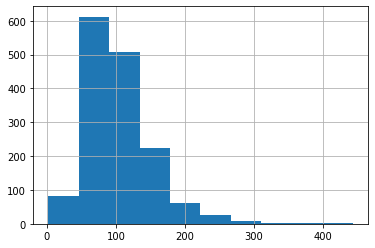

In [13]:
phd['tokens'].str.len().hist()

### 2. 키워드 추출

In [17]:
# 두 시기 구분 컬럼 추가 (2000년대 vs 2010년대) #
phd['period'] = pd.Series()
phd.loc[phd['출판년']<2010,'period'] = 0
phd.loc[phd['출판년']>=2010,'period'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [16]:
# 2000년대 : 813편, 2010년대 : 715편
phd['period'].value_counts()

0.0    813
1.0    715
Name: period, dtype: int64